# Objetivo do notebook é aplicar os conceitos apresentados no paper "Mean–variance portfolio optimization using machine learning-based", de Wei Chen et. all.

## [Link](https://www.sciencedirect.com/science/article/abs/pii/S1568494620308814 "Artigo")

In [75]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib.ticker as mtick
import seaborn as sns
import yfinance as yf

style.use('ggplot')

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV, KFold


In [76]:
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [77]:
#!pip install yfinance
#yf.pdr_override()
#!pip install stldecompose

In [78]:

#Lista dos 24 ativos abordados pelo autor, todos parte do índice SSE 50, da Bolsa de Shanghai:

ativos = ['600000.SS', '600018.SS', '600028.SS', '600029.SS', '600031.SS', '600048.SS', '600050.SS', '600089.SS', '600100.SS', '600156.SS', '600547.SS', '600637.SS', '600690.SS', '600837.SS',	'600887.SS', '600999.SS', '601006.SS', '601088.SS', '601111.SS', '601166.SS', '601186.SS', '601688.SS', '601766.SS', '601988.SS']

#O autor avalia os ativos entre novembro/2009 e novembro/2019:
inicio = dt.datetime(2009,11,1)
fim = dt.datetime(2019,11,30)

In [79]:
#Um teste para avaliar o primeiro dos ativos:
teste = yf.download("600000.SS", start=inicio, end=fim)
teste

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2009-11-02   8.772292   9.632970   8.722638   9.504696   6.291415  265173584
2009-11-03   9.517110   9.661935   9.475731   9.587453   6.346194  207655706
2009-11-04   9.562626   9.968138   9.521247   9.794347   6.483143  235029795
2009-11-05   9.757106   9.889518   9.670211   9.744693   6.450275  126982654
2009-11-06   9.848140   9.992965   9.724003   9.777796   6.472187  154066548
...               ...        ...        ...        ...        ...        ...
2019-11-25  12.030000  12.140000  12.000000  12.070000  10.896770   25153256
2019-11-26  12.150000  12.170000  11.980000  12.060000  10.887743   59633264
2019-11-27  12.070000  12.070000  11.900000  11.990000  10.824547   28703956
2019-11-28  12.000000  12.010000  11.920000  11.960000  10.797462   17797225
2019-11-29  11.930000  12.070000  11.890000  11.910000  10.752322   24566935

[2410 rows x 6 columns]

In [80]:
# Baixando os dados e organizando num DF:

df_ativos = pd.DataFrame(columns = teste.columns)

for ativo in ativos:
    
    dados = yf.download(ativo, inicio, fim)
    dados['Ativo'] = ativo 
    df_ativos = pd.concat([df_ativos, dados])
    
    
    print(f"Iniciando o download de {ativo}...")
    

[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600000.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600018.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600028.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600029.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600031.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600048.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600050.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600089.SS...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de 600100.SS...
[*********************100%********************

In [81]:
df_ativos.shape

(57539, 7)

In [ ]:
df_ativos.head()

In [82]:
df_ativos

Open      High       Low     Close  Adj Close     Volume  \
2009-11-02  8.772292  9.632970  8.722638  9.504696   6.291415  265173584   
2009-11-03  9.517110  9.661935  9.475731  9.587453   6.346194  207655706   
2009-11-04  9.562626  9.968138  9.521247  9.794347   6.483143  235029795   
2009-11-05  9.757106  9.889518  9.670211  9.744693   6.450275  126982654   
2009-11-06  9.848140  9.992965  9.724003  9.777796   6.472187  154066548   
...              ...       ...       ...       ...        ...        ...   
2019-11-25  3.610000  3.660000  3.610000  3.650000   3.256570   85133202   
2019-11-26  3.660000  3.680000  3.640000  3.670000   3.274414  149997057   
2019-11-27  3.670000  3.670000  3.650000  3.660000   3.265492   47606200   
2019-11-28  3.660000  3.660000  3.640000  3.650000   3.256570   52741532   
2019-11-29  3.650000  3.650000  3.620000  3.630000   3.238726   80189816   

                Ativo  
2009-11-02  600000.SS  
2009-11-03  600000.SS  
2009-11-04  600000.SS  
2009-11-05  600000.SS  
2009-11-06  600000.SS  
...               ...  
2019-11-25  601988.SS  
2019-11-26  601988.SS  
2019-11-27  601988.SS  
2019-11-28  601988.SS  
2019-11-29  601988.SS  

[57539 rows x 7 columns]

In [83]:
df_ativos.sort_index(inplace=True) #Organizando o df por datas

In [84]:
df_ativos.isna().sum() #Nenhum dado nulo...

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ativo        0
dtype: int64

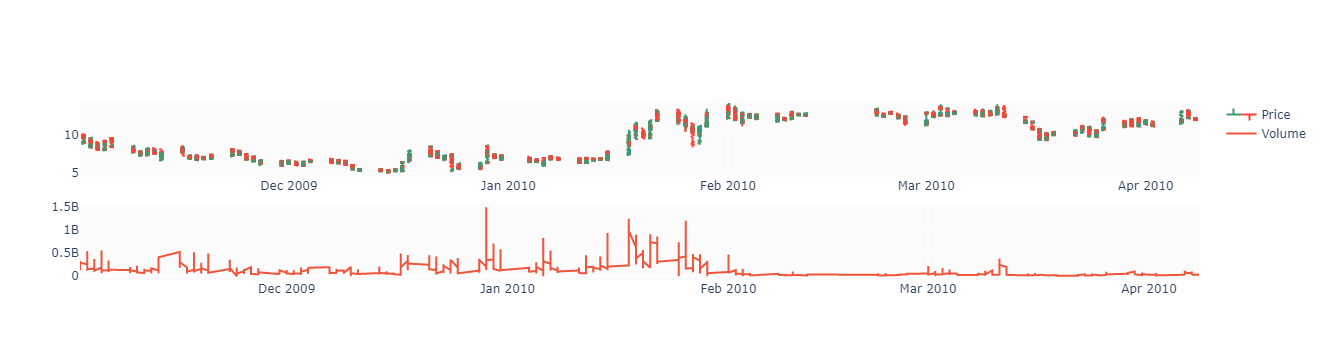

In [85]:
#Exemplo do que estamos lidando: Ativo 1:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df_ativos.index,
                      open=df_ativos[df_ativos['Ativo']=='600000.SS'].Open,
                      high=df_ativos[df_ativos['Ativo']=='600000.SS'].High,
                      low=df_ativos[df_ativos['Ativo']=='600000.SS'].Low,
                      close=df_ativos[df_ativos['Ativo']=='600000.SS'].Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_ativos.index, y=df_ativos[df_ativos['Ativo']=='600000.SS'].Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

## Métricas apresentadas pelo autor no artigo:

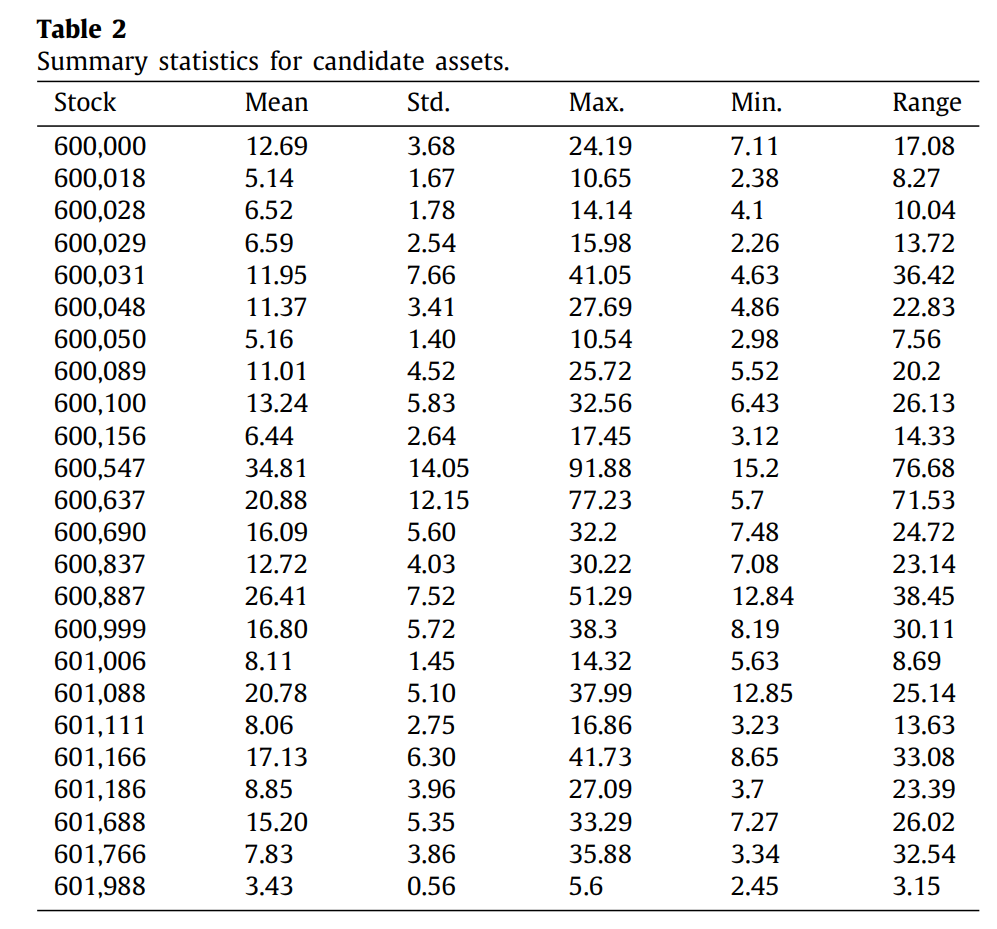

In [86]:
df_ativos.groupby(['Ativo']).mean() #Médias de preço de fechamento ['Close'] próximos aos que foram obtidos pelo autor, com algumas exceções

Open       High        Low      Close  Adj Close
Ativo                                                           
600000.SS   9.296733   9.407926   9.195210   9.301931   7.410893
600018.SS   5.156924   5.236524   5.078920   5.160525   4.317566
600028.SS   5.821015   5.889958   5.756874   5.826661   4.069470
600029.SS   6.621151   6.755156   6.496077   6.631513   6.258508
600031.SS   9.414674   9.572310   9.260949   9.419382   8.387380
600048.SS   8.741566   8.912498   8.590429   8.755348   7.251549
600050.SS   5.170475   5.256354   5.093094   5.176923   4.831076
600089.SS   9.676878   9.820226   9.527127   9.669259   8.395360
600100.SS  11.317607  11.548589  11.113394  11.324803  10.850935
600156.SS   6.415610   6.569802   6.279049   6.426428   6.414240
600547.SS  16.773751  17.059211  16.525542  16.806635  16.408020
600637.SS  16.352174  16.676117  16.046960  16.360707  14.376806
600690.SS   9.979656  10.148693   9.818957   9.993146   9.045160
600837.SS  12.715805  12.939185  12.521979  12.724244  11.213308
600887.SS  15.111956  15.361684  14.878786  15.126693  13.297135
600999.SS  15.922828  16.214782  15.674269  15.936417  14.050750
601006.SS   8.110167   8.210938   8.013019   8.114479   5.450315
601088.SS  20.743338  21.021043  20.478237  20.747408  13.139123
601111.SS   8.108462   8.266513   7.962981   8.120485   7.583237
601166.SS  13.298276  13.468143  13.149040  13.306529  10.419658
601186.SS   8.865016   9.014484   8.726406   8.870861   7.995764
601688.SS  15.233902  15.538079  14.979522  15.249530  13.836316
601766.SS   7.866947   7.992512   7.739336   7.865958   7.033204
601988.SS   3.429241   3.462095   3.398572   3.433407   2.419867

In [87]:
df_ativos.groupby(['Ativo']).count() # -> Nem todos os ativos apresentam cotação para todo o período, porém há dados que cobrem grande parte do espectro temporal para cada ativo.

Open  High   Low  Close  Adj Close  Volume
Ativo                                                
600000.SS  2410  2410  2410   2410       2410    2410
600018.SS  2399  2399  2399   2399       2399    2399
600028.SS  2450  2450  2450   2450       2450    2450
600029.SS  2432  2432  2432   2432       2432    2432
600031.SS  2448  2448  2448   2448       2448    2448
600048.SS  2448  2448  2448   2448       2448    2448
600050.SS  2356  2356  2356   2356       2356    2356
600089.SS  2431  2431  2431   2431       2431    2431
600100.SS  2307  2307  2307   2307       2307    2307
600156.SS  2419  2419  2419   2419       2419    2419
600547.SS  2269  2269  2269   2269       2269    2269
600637.SS  2226  2226  2226   2226       2226    2226
600690.SS  2362  2362  2362   2362       2362    2362
600837.SS  2441  2441  2441   2441       2441    2441
600887.SS  2421  2421  2421   2421       2421    2421
600999.SS  2434  2434  2434   2434       2434    2434
601006.SS  2439  2439  2439   2439       2439    2439
601088.SS  2388  2388  2388   2388       2388    2388
601111.SS  2412  2412  2412   2412       2412    2412
601166.SS  2435  2435  2435   2435       2435    2435
601186.SS  2440  2440  2440   2440       2440    2440
601688.SS  2363  2363  2363   2363       2363    2363
601766.SS  2365  2365  2365   2365       2365    2365
601988.SS  2444  2444  2444   2444       2444    2444

In [88]:
#path = r"C:\Users\Alexandre\OneDrive\Documentos\1. PRO\Data Science\Projeto Integrador\Apoio\Abner"
#df_ativos.to_csv(path_or_buf = path+"df_ativos.csv" )

## O paper traz uma série de dados de entrada, que vamos preparar na sequência. São eles:

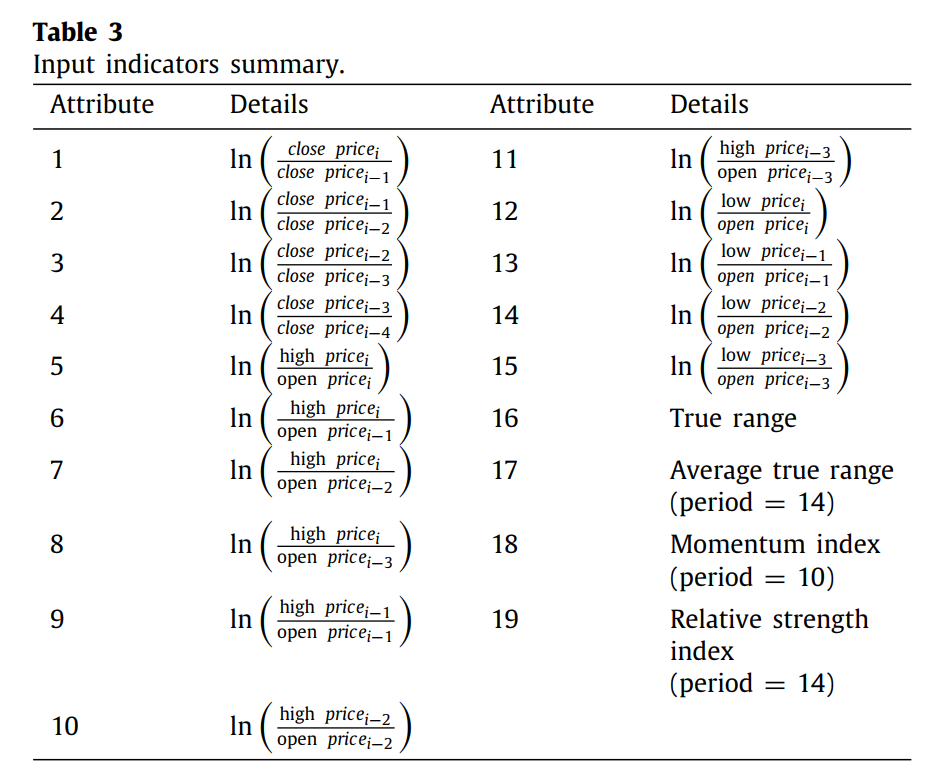

Como se pode observar, são 15 variáveis que envolvem relações temporais entre preços (open, close, high, low), além de 4 outras features muito utilizadas (True Range, Average True Range | 14d, Momentum Index | 10d, Relative Strength Index | 14d).

Na sequência, vamos criar todas essas varíaveis com base nos dados já levantados. Siglas:

* O - Open Price para um dia *"i"* específico
* C - Close Price para um dia *"i"* específico
* H - Highest Price para um dia *"i"* específico
* L - Lowest Price para um dia *"i"* específico



In [89]:
#Criando as features de entrada no DataFrame:

df_ativos['1: ln(C/C-1)'] = pd.Series(dtype=float)
df_ativos['2: ln(C-1/C-2)'] = pd.Series(dtype=float)
df_ativos['3: ln(C-2/C-3)'] = pd.Series(dtype=float)
df_ativos['4: ln(C-3/C-4)'] = pd.Series(dtype=float)
df_ativos['5: ln(H/O)'] = pd.Series(dtype=float)
df_ativos['6: ln(H/O-1)'] = pd.Series(dtype=float)
df_ativos['7: ln(H/O-2)'] = pd.Series(dtype=float)
df_ativos['8: ln(H/O-3)'] = pd.Series(dtype=float)
df_ativos['9: ln(H-1/O-1)'] = pd.Series(dtype=float)
df_ativos['10: ln(H-2/O-2)'] = pd.Series(dtype=float)
df_ativos['11: ln(H-3/O-3)'] = pd.Series(dtype=float)
df_ativos['12: ln(L/O)'] = pd.Series(dtype=float)
df_ativos['13: ln(L-1/O-1)'] = pd.Series(dtype=float)
df_ativos['14: ln(L-2/O-2)'] = pd.Series(dtype=float)
df_ativos['15: ln(L-3/O-3)'] = pd.Series(dtype=float)
df_ativos['16: True Range'] = pd.Series(dtype=float)
df_ativos['17: ATR 14d'] = pd.Series(dtype=float)
df_ativos['18: MI 10d'] = pd.Series(dtype=float)
df_ativos['19: RSI 14d'] = pd.Series(dtype=float)

In [90]:
#Calculando as variáveis com logaritmos naturais "lagged":

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'1: ln(C/C-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'2: ln(C-1/C-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'3: ln(C-2/C-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'4: ln(C-3/C-4)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(4))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'5: ln(H/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'6: ln(H/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'7: ln(H/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'8: ln(H/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'9: ln(H-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'10: ln(H-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'11: ln(H-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'12: ln(L/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'13: ln(L-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'14: ln(L-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'15: ln(L-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))

Variáveis True Range e Average True Range (Explicadas aqui: https://www.investopedia.com/terms/a/atr.asp#:~:text=The%20true%20range%20indicator%20is,days%2C%20of%20the%20true%20ranges.):

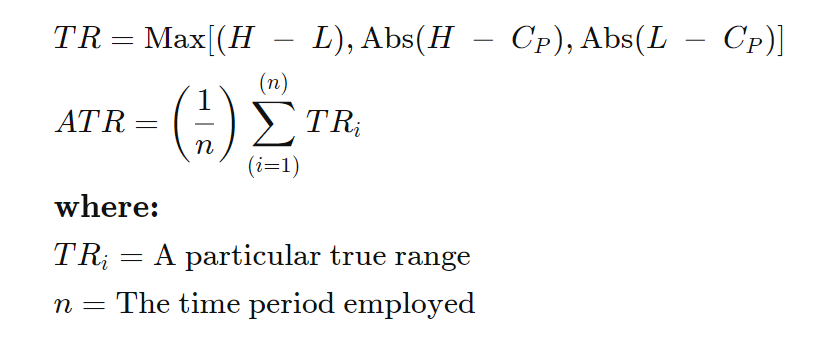



In [91]:
#Calculando as variáveis True Range e Average True Range | 14d:

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'] = np.nanmax([np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low']), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1)), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1))], axis=0)
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17: ATR 14d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=14).mean()
    
    



In [92]:
#Calculando a variável MSI | 10d (corresponde à diferença de preços entre o dia atual e o décimo dia anterior. Detalhes: https://help.eaglesmarkets.com/hc/en-us/articles/900002105843-What-are-the-MTM-indicators-Detailed-explanation-of-MTM-index):

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18: MI 10d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(10)


In [93]:
#Função para calcular RSI: [Créditos para https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction, levemente modificado para comportar diversos ativos]

def relative_strength_idx(df, ativo, n=14):
    close = df[df['Ativo']==ativo]['Close']
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ativo in ativos:

    df_ativos.loc[df_ativos['Ativo'] == ativo,'19: RSI 14d'] = relative_strength_idx(df_ativos,ativo)
    

In [94]:
#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.

#df_ativos['Close'] = df_ativos['Close'].shift(-1)

In [95]:
df_ativos

Open       High        Low      Close  Adj Close     Volume  \
2009-11-02   8.772292   9.632970   8.722638   9.504696   6.291415  265173584   
2009-11-02   8.600000   8.820000   8.570000   8.810000   7.133256   42974520   
2009-11-02  12.773433  13.999237  12.714232  13.960930   9.224529   79459915   
2009-11-02   7.350000   7.710000   7.300000   7.700000   6.815101   38635703   
2009-11-02  33.349998  35.799999  33.200001  35.689999  18.654739   20350805   
...               ...        ...        ...        ...        ...        ...   
2019-11-29  14.810000  14.840000  14.360000  14.480000  13.910461   59743226   
2019-11-29   6.620000   6.640000   6.570000   6.610000   6.610000   15916007   
2019-11-29   5.000000   5.010000   4.960000   4.990000   4.554284   45805196   
2019-11-29  29.379999  29.660000  28.820000  29.090000  27.729485   40688958   
2019-11-29   3.650000   3.650000   3.620000   3.630000   3.238726   80189816   

                Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  ...  \
2009-11-02  600000.SS           NaN             NaN             NaN  ...   
2009-11-02  601186.SS           NaN             NaN             NaN  ...   
2009-11-02  601166.SS           NaN             NaN             NaN  ...   
2009-11-02  601111.SS           NaN             NaN             NaN  ...   
2009-11-02  601088.SS           NaN             NaN             NaN  ...   
...               ...           ...             ...             ...  ...   
2019-11-29  600031.SS     -0.024558       -0.003364       -0.003352  ...   
2019-11-29  600029.SS     -0.004528       -0.001505       -0.011958  ...   
2019-11-29  600028.SS     -0.004000       -0.001994       -0.001990  ...   
2019-11-29  600887.SS     -0.010600       -0.002717        0.004419  ...   
2019-11-29  601988.SS     -0.005495       -0.002736       -0.002729  ...   

            10: ln(H-2/O-2)  11: ln(H-3/O-3)  12: ln(L/O)  13: ln(L-1/O-1)  \
2009-11-02              NaN              NaN    -0.005676              NaN   
2009-11-02              NaN              NaN    -0.003495              NaN   
2009-11-02              NaN              NaN    -0.004645              NaN   
2009-11-02              NaN              NaN    -0.006826              NaN   
2009-11-02              NaN              NaN    -0.004508              NaN   
...                     ...              ...          ...              ...   
2019-11-29         0.012016         0.003341    -0.030856        -0.012146   
2019-11-29         0.002981         0.005961    -0.007581        -0.004535   
2019-11-29         0.003976         0.001986    -0.008032        -0.005994   
2019-11-29         0.011553         0.011895    -0.019245        -0.008502   
2019-11-29         0.000000         0.005450    -0.008253        -0.005479   

            14: ln(L-2/O-2)  15: ln(L-3/O-3)  16: True Range  17: ATR 14d  \
2009-11-02              NaN              NaN        0.910332          NaN   
2009-11-02              NaN              NaN        0.250000          NaN   
2009-11-02              NaN              NaN        1.285005          NaN   
2009-11-02              NaN              NaN        0.410000          NaN   
2009-11-02              NaN              NaN        2.599998          NaN   
...                     ...              ...             ...          ...   
2019-11-29        -0.008769        -0.013477        0.480000     0.345000   
2019-11-29        -0.010503        -0.007502        0.070000     0.101429   
2019-11-29        -0.005994        -0.007984        0.050000     0.048572   
2019-11-29        -0.005483        -0.003082        0.840000     0.545000   
2019-11-29        -0.005464        -0.005479        0.030000     0.030714   

            18: MI 10d  19: RSI 14d  
2009-11-02         NaN          NaN  
2009-11-02         NaN          NaN  
2009-11-02         NaN          NaN  
2009-11-02         NaN          NaN  
2009-11-02         NaN          NaN  
...                ...          ...  
2019-11-29    0

In [96]:
df_ativos_sna = df_ativos.dropna() #Muitas métricas precisam de mais dias de medição, de forma que os primeiros são nulos. Ao final, partimos do dia 20/11/2009 para a análise. Lembrando que aqui dropamos as ocorrências intrinsecamente ligadas a cada ativo, de forma que um ativo não atrapalha o outro.
df_ativos_sna

Open       High        Low      Close  Adj Close     Volume  \
2009-11-20   6.080000   6.180000   6.010000   6.140000   6.106318   10077910   
2009-11-20   4.213768   4.233142   4.175021   4.204082   2.267983   77086308   
2009-11-20   4.646666   4.691666   4.583333   4.641666   3.721854   27519906   
2009-11-20   9.786071   9.844002   9.591591   9.773658   6.469447  237327779   
2009-11-20  14.107191  14.197734  13.859941  13.988790   9.242937   71807460   
...               ...        ...        ...        ...        ...        ...   
2019-11-29  14.810000  14.840000  14.360000  14.480000  13.910461   59743226   
2019-11-29   6.620000   6.640000   6.570000   6.610000   6.610000   15916007   
2019-11-29   5.000000   5.010000   4.960000   4.990000   4.554284   45805196   
2019-11-29  29.379999  29.660000  28.820000  29.090000  27.729485   40688958   
2019-11-29   3.650000   3.650000   3.620000   3.630000   3.238726   80189816   

                Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  ...  \
2009-11-20  600156.SS      0.009820        0.018258       -0.005013  ...   
2009-11-20  601988.SS     -0.006889       -0.002286        0.018434  ...   
2009-11-20  600887.SS     -0.009293        0.002850        0.011482  ...   
2009-11-20  600000.SS     -0.007592       -0.007534       -0.002499  ...   
2009-11-20  601166.SS     -0.016297       -0.012655       -0.009148  ...   
...               ...           ...             ...             ...  ...   
2019-11-29  600031.SS     -0.024558       -0.003364       -0.003352  ...   
2019-11-29  600029.SS     -0.004528       -0.001505       -0.011958  ...   
2019-11-29  600028.SS     -0.004000       -0.001994       -0.001990  ...   
2019-11-29  600887.SS     -0.010600       -0.002717        0.004419  ...   
2019-11-29  601988.SS     -0.005495       -0.002736       -0.002729  ...   

            10: ln(H-2/O-2)  11: ln(H-3/O-3)  12: ln(L/O)  13: ln(L-1/O-1)  \
2009-11-20         0.003339         0.035268    -0.011580        -0.011755   
2009-11-20         0.016074         0.016185    -0.009238        -0.011481   
2009-11-20         0.025136         0.010714    -0.013724        -0.000714   
2009-11-20         0.007041         0.015994    -0.020073        -0.019345   
2009-11-20         0.006452         0.019243    -0.017682        -0.028068   
...                     ...              ...          ...              ...   
2019-11-29         0.012016         0.003341    -0.030856        -0.012146   
2019-11-29         0.002981         0.005961    -0.007581        -0.004535   
2019-11-29         0.003976         0.001986    -0.008032        -0.005994   
2019-11-29         0.011553         0.011895    -0.019245        -0.008502   
2019-11-29         0.000000         0.005450    -0.008253        -0.005479   

            14: ln(L-2/O-2)  15: ln(L-3/O-3)  16: True Range  17: ATR 14d  \
2009-11-20        -0.020271        -0.006861        0.170000     0.194286   
2009-11-20        -0.006969        -0.004673        0.058121     0.067808   
2009-11-20        -0.011704        -0.024719        0.108333     0.157024   
2009-11-20        -0.008766        -0.007886        0.256549     0.246794   
2009-11-20        -0.016925        -0.004568        0.358687     0.397242   
...                     ...              ...             ...          ...   
2019-11-29        -0.008769        -0.013477        0.480000     0.345000   
2019-11-29        -0.010503        -0.007502        0.070000     0.101429   
2019-11-29        -0.005994        -0.007984        0.050000     0.048572   
2019-11-29        -0.005483        -0.003082        0.840000     0.545000   
2019-11-29        -0.005464        -0.005479        0.030000     0.030714   

            18: MI 10d  19: RSI 14d  
2009-11-20    0.520000    78.260822  
2009-11-20    0.164676    75.000185  
2009-11-20    0.478333    79.465748  
2009-11-20   -0.004138    61.732851  
2009-11-20   -0.107954    50.554026  
...                ...          ...  
2019-11-29    0

In [97]:
#Dúvida que não quer calar: Usar tudo pra fazer um modelo só (passando OneHotEncoder na feature 'Ativo' e deixando os preços dos ativos se autoinfluenciarem) ou fazer um modelo pra cada ativo?!

In [98]:
#Um modelo pra cada ativo parece fazer mais sentido... 
#Acho que o melhor caminho seria por um dicionário de DFs, uma entrada pra cada ativo.
#Separando os dataframes para cada Ativo em um dicionário, para  e gerar as features de interesse:

dict_ativos = {}

for ativo in ativos:
    dict_ativos[ativo] = df_ativos_sna[df_ativos_sna['Ativo']==ativo]
    

In [99]:
dict_ativos

{'600000.SS':                  Open       High        Low      Close  Adj Close     Volume  \
 2009-11-20   9.786071   9.844002   9.591591   9.773658   6.469447  237327779   
 2009-11-23   9.769520   9.781934   9.620556   9.761244   6.461230  199065555   
 2009-11-24   9.831588   9.860553   9.496420   9.521247   6.302371  310931094   
 2009-11-25   9.558488   9.620556   9.244010   9.591591   6.348933  270931594   
 2009-11-26   9.550213   9.550213   9.061943   9.099184   6.022995  326594191   
 ...               ...        ...        ...        ...        ...        ...   
 2019-11-25  12.030000  12.140000  12.000000  12.070000  10.896770   25153256   
 2019-11-26  12.150000  12.170000  11.980000  12.060000  10.887743   59633264   
 2019-11-27  12.070000  12.070000  11.900000  11.990000  10.824547   28703956   
 2019-11-28  12.000000  12.010000  11.920000  11.960000  10.797462   17797225   
 2019-11-29  11.930000  12.070000  11.890000  11.910000  10.752322   24566935   
 
             

In [149]:
#Fazendo um split do dataset em 80% treino, 20% teste e armazenando cada um em dicionário específico, já retirando as variáveis não desejadas: 

test_size  = 0.20

dict_train = {}
dict_test = {}

dict_X_train = {}
dict_X_test = {}

dict_y_train = {}
dict_y_test = {}


lista_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo']

for ativo, df in dict_ativos.items():

    test_split_idx  = int(df.shape[0] * (1-test_size))

#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.
  
    
    df['Close'] = df.loc[:,'Close'].shift(-1) #Gera um NA, então vamos ter que dropar novamente...
    df.dropna(inplace=True)
    
    df_train  = df.iloc[:test_split_idx].copy()
    df_test   = df.iloc[test_split_idx+1:].copy()
    
    X_train = df_train.drop(columns = lista_drop).drop(columns='Close')
    X_test = df_test.drop(columns = lista_drop).drop(columns='Close')
    
    y_train = df_train['Close']
    y_test = df_test['Close']

    dict_train[ativo] = df_train.drop(columns = lista_drop)
    dict_test[ativo] = df_test.drop(columns = lista_drop)
    
    dict_X_train[ativo] = X_train
    dict_X_test[ativo] = X_test
    
    dict_y_train[ativo] = y_train
    dict_y_test[ativo] = y_test

<ipython-input-149-d1b77a5251b1>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-149-d1b77a5251b1>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-149-d1b77a5251b1>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-149-d1b77a5251b1>:26: SettingWithCopyWarning:


A value is tr

In [150]:
df_train

Open      High       Low     Close  Adj Close     Volume  \
2009-11-20  4.213768  4.233142  4.175021  4.116900   2.267983   77086308   
2009-11-23  4.213768  4.233142  4.184708  4.145961   2.273209   63293791   
2009-11-24  4.242829  4.281576  4.107213  4.000658   2.220951  126624641   
2009-11-25  4.087840  4.145961  4.010345  3.913477   2.236629  112735634   
2009-11-26  4.126587  4.126587  3.961911  3.990971   2.158242  133464362   
...              ...       ...       ...       ...        ...        ...   
2017-11-22  3.940000  4.040000  3.930000  4.000000   3.266042  404924420   
2017-11-23  4.020000  4.070000  3.970000  3.950000   3.241729  328517393   
2017-11-24  3.990000  4.030000  3.960000  3.920000   3.241729  182082353   
2017-11-27  3.990000  3.990000  3.900000  3.930000   3.201207  303061902   
2017-11-28  3.930000  3.940000  3.890000  3.930000   3.176895  158778834   

                Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  ...  \
2009-11-20  601988.SS     -0.006889       -0.002286        0.018434  ...   
2009-11-23  601988.SS      0.002301       -0.006889       -0.002286  ...   
2009-11-24  601988.SS     -0.023257        0.002301       -0.006889  ...   
2009-11-25  601988.SS      0.007034       -0.023257        0.002301  ...   
2009-11-26  601988.SS     -0.035676        0.007034       -0.023257  ...   
...               ...           ...             ...             ...  ...   
2017-11-22  601988.SS      0.027675       -0.005089        0.005089  ...   
2017-11-23  601988.SS     -0.007472        0.027675       -0.005089  ...   
2017-11-24  601988.SS      0.000000       -0.007472        0.027675  ...   
2017-11-27  601988.SS     -0.012579        0.000000       -0.007472  ...   
2017-11-28  601988.SS     -0.007624       -0.012579        0.000000  ...   

            10: ln(H-2/O-2)  11: ln(H-3/O-3)  12: ln(L/O)  13: ln(L-1/O-1)  \
2009-11-20         0.016074         0.016185    -0.009238        -0.011481   
2009-11-23         0.004556         0.016074    -0.006920        -0.009238   
2009-11-24         0.004587         0.004556    -0.032486        -0.006920   
2009-11-25         0.004587         0.004587    -0.019139        -0.032486   
2009-11-26         0.009091         0.004587    -0.040724        -0.019139   
...                     ...              ...          ...              ...   
2017-11-22         0.012707         0.023108    -0.002541        -0.007643   
2017-11-23         0.010101         0.012707    -0.012516        -0.002541   
2017-11-24         0.025064         0.010101    -0.007547        -0.012516   
2017-11-27         0.012361         0.025064    -0.022815        -0.007547   
2017-11-28         0.009975         0.012361    -0.010230        -0.022815   

            14: ln(L-2/O-2)  15: ln(L-3/O-3)  16: True Range  17: ATR 14d  \
2009-11-20        -0.006969        -0.004673        0.058121     0.067808   
2009-11-23        -0.011481        -0.006969        0.048434     0.067808   
2009-11-24        -0.009238        -0.011481        0.174363     0.076111   
2009-11-25        -0.006920        -0.009238        0.135616     0.079570   
2009-11-26        -0.032486        -0.006920        0.184050     0.085798   
...                     ...              ...             ...          ...   
2017-11-22        -0.005128        -0.002601        0.120000     0.062143   
2017-11-23        -0.007643        -0.005128        0.100000     0.065714   
2017-11-24        -0.002541        -0.007643        0.070000     0.067857   
2017-11-27        -0.012516        -0.002541        0.100000     0.070000   
2017-11-28        -0.007547        -0.012516        0.060000     0.070714   

            18: MI 10d  19: RSI 14d  
2009-11-20    0.164676    75.000185  
2009-11-23    0.164676    75.609888  
2009-11-24    0.058121    60.000039  
2009-11-25    0.087182    58.333385  
2009-11-26   -0.029061    46.666612  
...                ...          ...  
2017-11-22    0.080000    64.583307  
2017-11-23    0.080000  

In [104]:
#Acessando, por exemplo, o df_train do primeiro ativo:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2009-11-20   9.761244     -0.007592       -0.007534       -0.002499   
2009-11-23   9.521247     -0.001271       -0.007592       -0.007534   
2009-11-24   9.591591     -0.024894       -0.001271       -0.007592   
2009-11-25   9.099184      0.007361       -0.024894       -0.001271   
2009-11-26   8.879877     -0.052702        0.007361       -0.024894   
...               ...           ...             ...             ...   
2017-11-30  12.910000     -0.002321        0.000000       -0.012289   
2017-12-01  12.920000      0.000000       -0.002321        0.000000   
2017-12-04  13.170000      0.000774        0.000000       -0.002321   
2017-12-05  12.960000      0.019165        0.000774        0.000000   
2017-12-06  12.960000     -0.016074        0.019165        0.000774   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2009-11-20        0.001249    0.005902     -0.009205     -0.011285   
2009-11-23       -0.002499    0.001270     -0.000423     -0.015530   
2009-11-24       -0.007534    0.002942      0.009275      0.007582   
2009-11-25       -0.007592    0.006473     -0.021698     -0.015365   
2009-11-26       -0.001271    0.000000     -0.000866     -0.029037   
...                    ...         ...           ...           ...   
2017-11-30        0.000764    0.003094      0.000000     -0.006159   
2017-12-01       -0.012289    0.001546      0.003094      0.000000   
2017-12-04        0.000000    0.005424      0.000773      0.002321   
2017-12-05       -0.002321    0.026729      0.030607      0.025956   
2017-12-06        0.000000    0.003044      0.018405      0.022283   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2009-11-20     -0.016674        0.005400         0.007041         0.015994   
2009-11-23     -0.017610        0.005902         0.005400         0.007041   
2009-11-24     -0.007525        0.001270         0.005902         0.005400   
2009-11-25     -0.017058        0.002942         0.001270         0.005902   
2009-11-26     -0.022704        0.006473         0.002942         0.001270   
...                  ...             ...              ...              ...   
2017-11-30     -0.010753        0.006926         0.003065         0.002289   
2017-12-01     -0.006159        0.003094         0.006926         0.003065   
2017-12-04     -0.000773        0.001546         0.003094         0.006926   
2017-12-05      0.027504        0.005424         0.001546         0.003094   
2017-12-06      0.017632        0.026729         0.005424         0.001546   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2009-11-20    -0.020073        -0.019345        -0.008766        -0.007886   
2009-11-23    -0.015365        -0.020073        -0.019345        -0.008766   
2009-11-24    -0.034686        -0.015365        -0.020073        -0.019345   
2009-11-25    -0.033454        -0.034686        -0.015365        -0.020073   
2009-11-26    -0.052480        -0.033454        -0.034686        -0.015365   
...                 ...              ...              ...              ...   
2017-11-30    -0.008557        -0.010870        -0.008478        -0.021622   
2017-12-01    -0.009324        -0.008557        -0.010870        -0.008478   
2017-12-04    -0.002334        -0.009324        -0.008557        -0.010870   
2017-12-05    -0.000774        -0.002334        -0.009324        -0.008557   
2017-12-06    -0.016136        -0.000774        -0.002334        -0.009324   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2009-11-20        0.256549     0.246794   -0.004138    61.732851  
2009-11-23        0.161378     0.245021    0.033103    58.076923  
2009-11-24        0.364133     0.239110   -0.198618    37.686572  
2009-11-25        0.376546     0.250341   -0.033103    43.223429  
2009-11-26        0.529648     0.268962   -0.463442    28.645844  
...                    ...          ...       

In [105]:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2009-11-20   9.761244     -0.007592       -0.007534       -0.002499   
2009-11-23   9.521247     -0.001271       -0.007592       -0.007534   
2009-11-24   9.591591     -0.024894       -0.001271       -0.007592   
2009-11-25   9.099184      0.007361       -0.024894       -0.001271   
2009-11-26   8.879877     -0.052702        0.007361       -0.024894   
...               ...           ...             ...             ...   
2017-11-30  12.910000     -0.002321        0.000000       -0.012289   
2017-12-01  12.920000      0.000000       -0.002321        0.000000   
2017-12-04  13.170000      0.000774        0.000000       -0.002321   
2017-12-05  12.960000      0.019165        0.000774        0.000000   
2017-12-06  12.960000     -0.016074        0.019165        0.000774   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2009-11-20        0.001249    0.005902     -0.009205     -0.011285   
2009-11-23       -0.002499    0.001270     -0.000423     -0.015530   
2009-11-24       -0.007534    0.002942      0.009275      0.007582   
2009-11-25       -0.007592    0.006473     -0.021698     -0.015365   
2009-11-26       -0.001271    0.000000     -0.000866     -0.029037   
...                    ...         ...           ...           ...   
2017-11-30        0.000764    0.003094      0.000000     -0.006159   
2017-12-01       -0.012289    0.001546      0.003094      0.000000   
2017-12-04        0.000000    0.005424      0.000773      0.002321   
2017-12-05       -0.002321    0.026729      0.030607      0.025956   
2017-12-06        0.000000    0.003044      0.018405      0.022283   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2009-11-20     -0.016674        0.005400         0.007041         0.015994   
2009-11-23     -0.017610        0.005902         0.005400         0.007041   
2009-11-24     -0.007525        0.001270         0.005902         0.005400   
2009-11-25     -0.017058        0.002942         0.001270         0.005902   
2009-11-26     -0.022704        0.006473         0.002942         0.001270   
...                  ...             ...              ...              ...   
2017-11-30     -0.010753        0.006926         0.003065         0.002289   
2017-12-01     -0.006159        0.003094         0.006926         0.003065   
2017-12-04     -0.000773        0.001546         0.003094         0.006926   
2017-12-05      0.027504        0.005424         0.001546         0.003094   
2017-12-06      0.017632        0.026729         0.005424         0.001546   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2009-11-20    -0.020073        -0.019345        -0.008766        -0.007886   
2009-11-23    -0.015365        -0.020073        -0.019345        -0.008766   
2009-11-24    -0.034686        -0.015365        -0.020073        -0.019345   
2009-11-25    -0.033454        -0.034686        -0.015365        -0.020073   
2009-11-26    -0.052480        -0.033454        -0.034686        -0.015365   
...                 ...              ...              ...              ...   
2017-11-30    -0.008557        -0.010870        -0.008478        -0.021622   
2017-12-01    -0.009324        -0.008557        -0.010870        -0.008478   
2017-12-04    -0.002334        -0.009324        -0.008557        -0.010870   
2017-12-05    -0.000774        -0.002334        -0.009324        -0.008557   
2017-12-06    -0.016136        -0.000774        -0.002334        -0.009324   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2009-11-20        0.256549     0.246794   -0.004138    61.732851  
2009-11-23        0.161378     0.245021    0.033103    58.076923  
2009-11-24        0.364133     0.239110   -0.198618    37.686572  
2009-11-25        0.376546     0.250341   -0.033103    43.223429  
2009-11-26        0.529648     0.268962   -0.463442    28.645844  
...                    ...          ...       

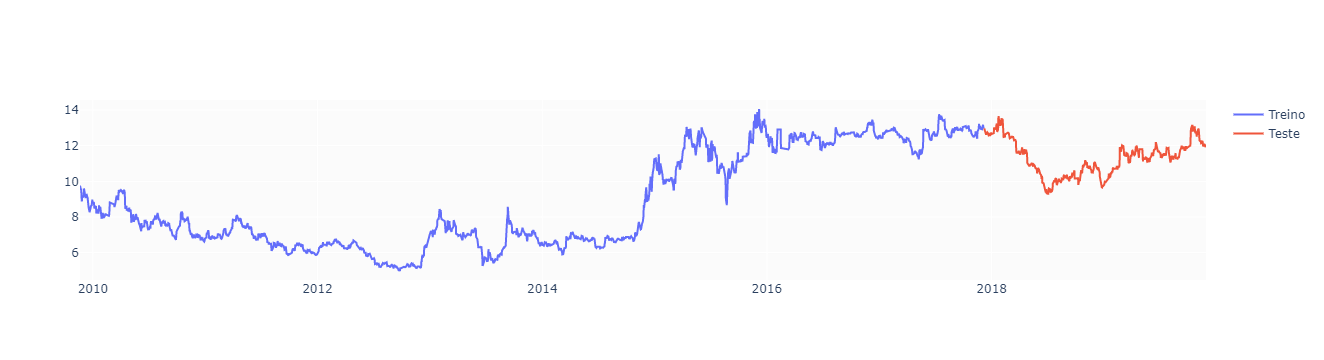

In [106]:
#Vamos ver a cara dessa bagaça e como ficaram temporalmente treino, validação e teste...
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(dict_train.values())[0].index, y=list(dict_train.values())[0].Close, name='Treino'))
fig.add_trace(go.Scatter(x=list(dict_test.values())[0].index,  y=list(dict_test.values())[0].Close,  name='Teste'))
fig.show()

In [107]:
#Ok, parece que temos tudo para começar a modelagem. Vamos ao que interessa...

In [108]:
#!pip install xgboost

In [109]:
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [110]:
#Vamos checar as variáveis de entrada para o primeiro ativo
list(dict_X_train.values())[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2009-11-20 to 2017-12-06
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1: ln(C/C-1)     1916 non-null   float64
 1   2: ln(C-1/C-2)   1916 non-null   float64
 2   3: ln(C-2/C-3)   1916 non-null   float64
 3   4: ln(C-3/C-4)   1916 non-null   float64
 4   5: ln(H/O)       1916 non-null   float64
 5   6: ln(H/O-1)     1916 non-null   float64
 6   7: ln(H/O-2)     1916 non-null   float64
 7   8: ln(H/O-3)     1916 non-null   float64
 8   9: ln(H-1/O-1)   1916 non-null   float64
 9   10: ln(H-2/O-2)  1916 non-null   float64
 10  11: ln(H-3/O-3)  1916 non-null   float64
 11  12: ln(L/O)      1916 non-null   float64
 12  13: ln(L-1/O-1)  1916 non-null   float64
 13  14: ln(L-2/O-2)  1916 non-null   float64
 14  15: ln(L-3/O-3)  1916 non-null   float64
 15  16: True Range   1916 non-null   float64
 16  17: ATR 14d      1916 non-null   float64
 

In [130]:
param = {
    'n_estimators': [50, 100, 200, 300, 400, 500], #Quanto maior, ficou melhor. -> Mudar o intervalo pra cima...
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], #Quanto maior, ficou melhor -> Mudar o intervalo pra cima...
    'max_depth': [3, 4, 5, 7, 10], #Quanto menor, ficou melhor -> Mudar o intervalo pra baixo...
    'gamma': [0.001, 0.003, 0.005, 0.007, 0.01], #No meio ficou melhor. Testar variações menores a partir do 0.005
    'random_state': [248]
}

#eval_set = [(list(dict_X_train.values())[0], (list(dict_y_train.values())[0])), (list(dict_X_valid.values())[0], (list(dict_y_valid.values())[0]))]
#eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse')

k = 10

kf = KFold(n_splits=k, shuffle = True, random_state = 248)

grid_s = GridSearchCV(model, param, cv=kf.split(list(dict_X_train.values())[0], list(dict_y_train.values())[0]) )

grid_s.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])

print(f'Best params: {grid_s.best_params_}')
print(f'Best validation score = {grid_s.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'random_state': 248}
Best validation score = 0.8791675453977827


In [131]:
#Setando o melhor modelo:

model = xgb.XGBRegressor(**grid_s.best_params_, objective='reg:squarederror', eval_metric = 'rmse')
model.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.005, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=6,
             num_parallel_tree=1, random_state=248, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

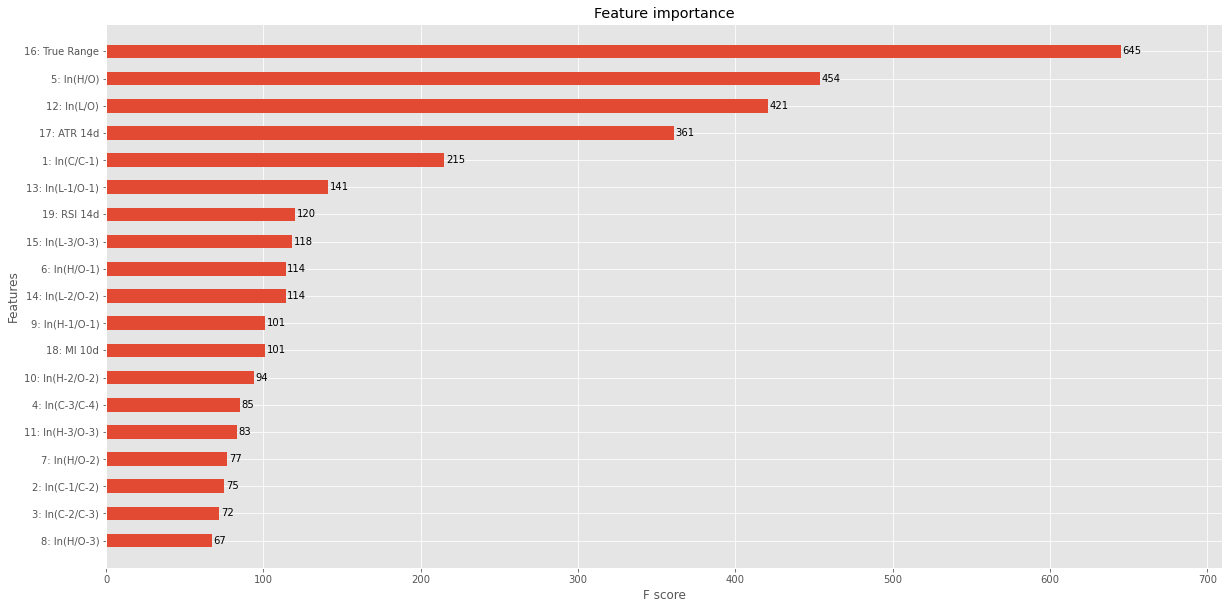

In [132]:
#Olhando Feature Importance:
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(model, height = 0.5)

In [152]:
#Verificando performance do modelo para o conjunto de testes desse primeiro ativo:

y_pred_train = model.predict(list(dict_X_train.values())[0])
y_pred_test = model.predict(list(dict_X_test.values())[0])

print(f'Treino: mean_squared_error = {mean_squared_error(list(dict_y_train.values())[0], y_pred_train)}')
print(f'Teste: mean_squared_error = {mean_squared_error(list(dict_y_test.values())[0], y_pred_test)}')

Treino: mean_squared_error = 0.14850921526582617
Teste: mean_squared_error = 0.9307906782493738


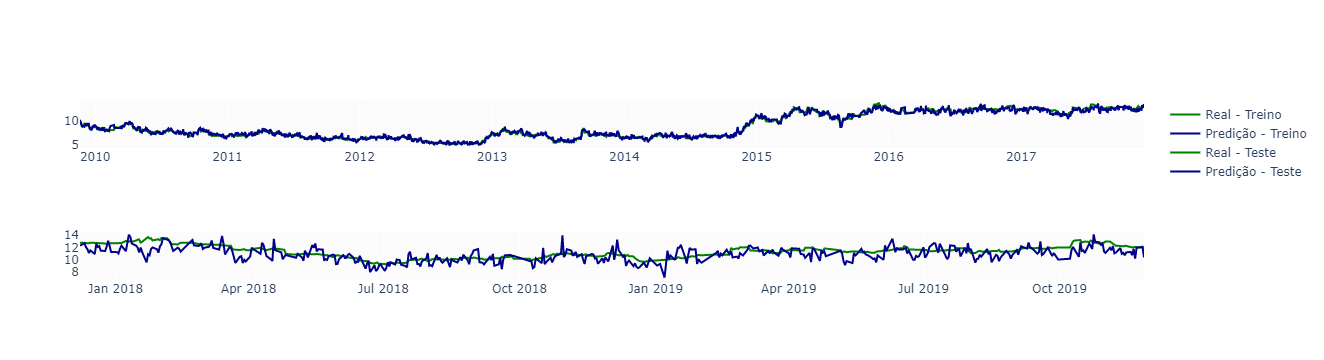

In [153]:
#Visualização para este único ativo:

pred_close_train = list(dict_train.values())[0].copy()
pred_close_test = list(dict_test.values())[0].copy()
pred_close = pd.concat([pred_close_train, pred_close_test ])

plt.rcParams["figure.figsize"] = (100, 20)
fig = make_subplots(rows=3, cols=1, )

fig.add_trace(go.Scatter(x=pred_close_train.index, y=list(dict_train.values())[0]['Close'],
                         name='Real - Treino',
                         marker_color='Green'), row=1, col=1)

fig.add_trace(go.Scatter(x=pred_close_train.index,
                         y=y_pred_train,
                         name='Predição - Treino',
                         marker_color='DarkBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=pred_close_test.index, y=list(dict_test.values())[0]['Close'],
                         name='Real - Teste',
                         marker_color='Green'), row=3, col=1)

fig.add_trace(go.Scatter(x=pred_close_test.index,
                         y=y_pred_test,
                         name='Predição - Teste',
                         marker_color='DarkBlue'), row=3, col=1)

fig.show()

## O Artigo trouxe as seguintes métricas, comparando o seu modelo aos outros testados:

<div>
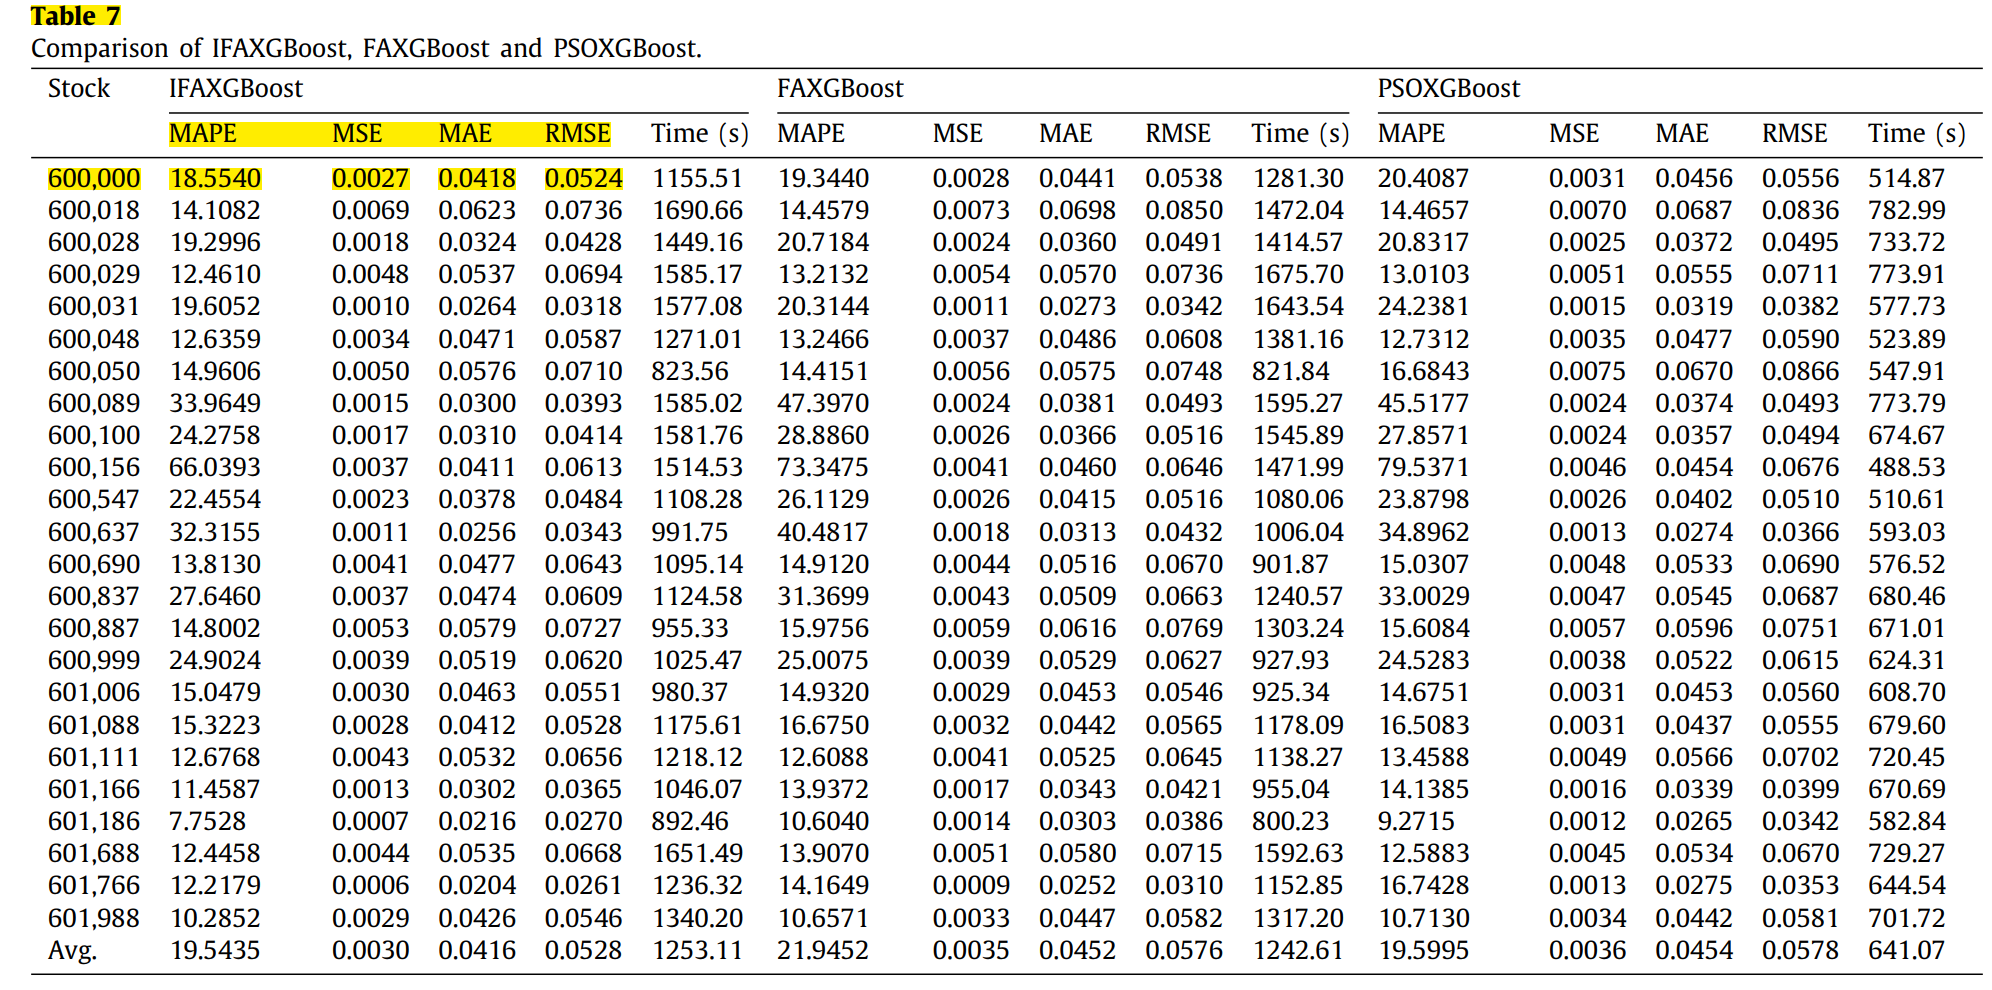
</div>


In [166]:
#Comparando MAPE, MSE, MAE e RMSE obtidos para o primeiro ativo com os do modelo do paper:

#from sklearn.metrics import mean_absolute_percentage_error -> Dando erro
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
MAPE_test = np.mean(np.abs((list(dict_test.values())[0]['Close'] - y_pred_test)/list(dict_test.values())[0]['Close']))
MSE_test = mean_squared_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test, squared = False)
MAE_test = mean_absolute_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test)
RMSE_test = mean_squared_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test, squared = True)

print("Performance prevendo o Ativo 600.000 (Teste):")
print(f'MAPE = {MAPE_test:.4f}')
print(f'MSE = {MSE_test:.4f}')
print(f'MAE = {MAE_test:.4f}')
print(f'RMSE = {RMSE_test:.4f}')

Performance prevendo o Ativo 600.000 (Teste):
MAPE = 0.0670
MSE = 0.9648
MAE = 0.7609
RMSE = 0.9308


In [167]:
#Checando as mesmas métricas no treino:

MAPE_train = np.mean(np.abs((list(dict_train.values())[0]['Close'] - y_pred_train)/list(dict_train.values())[0]['Close']))
MSE_train = mean_squared_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train, squared = False)
MAE_train = mean_absolute_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train)
RMSE_train = mean_squared_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train, squared = True)

print("Performance no treino com o Ativo 600.000:")
print(f'MAPE = {MAPE_train:.4f}')
print(f'MSE = {MSE_train:.4f}')
print(f'MAE = {MAE_train:.4f}')
print(f'RMSE = {RMSE_train:.4f}')

Performance no treino com o Ativo 600.000:
MAPE = 0.0351
MSE = 0.3854
MAE = 0.2982
RMSE = 0.1485


In [168]:
#Melhorar o tunning com base nos melhores parâmetros obtidos.

### Referência interessante em: https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction
### Biblioteca de params XGBoost: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#parameters-for-tree-booster
### GridSearch com crossval (atenção que é clf, não reg): https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

## Próximos passos: 
* Checar as métricas obtidas com as do paper (MSE, pelo menos);
* Entender com Abner o melhor approach para fitar os modelos para cada ativo (dicionário funciona, mas talvez seja mais simples) ;
* Melhorar o tunning do modelo -> Tentar implementar o IFA?
* Implementar a seleção de portfólio -> Mean-Variance;
* Testar com as cryptos e fazer o tunning novamente;
* Deploy!
